# Projekt - odovzdanie 3

**Autori:** Patrik Villant, Ivan Vykopal
 
**Cvičenie:** Utorok o 14:00
 
**Cvičiaci:** Ing. Peter Bakonyi
 
**Dátová sada:** 55
 
**Podiel práce:** 50/50

In [109]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import datetime
import math
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz2.44.1/bin/'

In [110]:
class MergeTransformer(TransformerMixin):
    def __init__(self, personal, other, columns=['name', 'address']):
        self.personal = personal
        self.other = other
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data = pd.merge(self.personal, self.other, on=self.columns, how = 'inner')
        return data

In [111]:
class SplittingMedicalTransformer(TransformerMixin):
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for i in range(len(data)):
            row = data.medical_info[i]
            if str(row) == 'nan':
                j ={'mean_glucose': np.nan,
                     'std_glucose': np.nan,
                     'kurtosis_glucose': np.nan,
                     'skewness_glucose': np.nan,
                     'mean_oxygen': np.nan,
                     'std_oxygen': np.nan,
                     'kurtosis_oxygen': np.nan,
                     'skewness_oxygen': np.nan}
            else:
                j = eval(str(row))
            data.at[i,'mean_glucose'] = float(j['mean_glucose'])
            data.at[i,'std_glucose'] = float(j['std_glucose'])
            data.at[i,'kurtosis_glucose'] = float(j['kurtosis_glucose'])
            data.at[i,'skewness_glucose'] = float(j['skewness_glucose'])
            data.at[i,'mean_oxygen'] = float(j['mean_oxygen'])
            data.at[i,'std_oxygen'] = float(j['std_oxygen'])
            data.at[i,'kurtosis_oxygen'] = float(j['kurtosis_oxygen'])
            data.at[i,'skewness_oxygen'] = float(j['skewness_oxygen'])
        data = data.drop(columns=['medical_info'])
        return data

In [112]:
class DeduplicationTransformer(TransformerMixin):
    def __init__(self, columns=['name', 'address']):
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        duplicates = data[data.duplicated(self.columns)]
        unique_names = duplicates.name.unique()
        for i in unique_names: 
            helper = data[data.name == i]
            helper = helper.fillna(method='ffill')
            helper = helper.drop_duplicates(self.columns, keep = 'last')
            data = data.append(helper)
    
        data.drop_duplicates(self.columns, inplace = True, keep = 'last')
        data = data.reset_index(drop = True)
        return data

In [113]:
class StripTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data[self.columns] = data[self.columns].apply(lambda x: x.str.strip())
        return data

In [114]:
class UnificationToNanTransformer(TransformerMixin):
    
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data.replace(to_replace=r'\?+', value=np.nan, regex=True, inplace=True)
        return data

In [115]:
class DateUnificationTransformer(TransformerMixin):
    
    def _unifyFormats(self, data):
        data = data[:10]
        date = re.sub('[0-9]','0', data)
        if date == '0000/00/00':
            data = data.replace('/', '-')
        if date == '00/00/0000':
            data = data[6:] + '-' + data[3:5] +'-' + data[:2]
        if date == '00-00-00':
            if data[0] == 0 or data[0] == 1:
                data = '20' + data[:2] + '-' + data[3:5] + '-' + data[6:]
            else:
                data = '19' + data[:2] + '-' + data[3:5] + '-' + data[6:]
        
        return data
    
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['date_of_birth'] = data['date_of_birth'].apply(self._unifyFormats)
        return data

In [116]:
class AddressUnificationTransformer(TransformerMixin):
    
    def _splittAddress(self, data):
        data['street'] = 'street'
        data['town'] = 'town'
        data['psc'] = 'psc'
        for i in range(len(data.address)):
            helper = re.split('\n|, ', data.address[i])
            data.loc[i, 'street'] = str(helper[0]).strip()
            data.loc[i, 'town'] = str(helper[1])
            if len(helper) == 2:
                data.loc[i, 'town'] = str(helper[1][:-8])
                data.loc[i, 'psc'] = str(helper[1][-8:])
            if len(helper) == 3:
                data.loc[i, 'psc'] = str(helper[2])
        data = data.drop(columns=['address'])
        return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data = self._splittAddress(data)
        return data

In [117]:
class AgeUnificationTransformer(TransformerMixin):
    
    def _unifyAge(self, data):
        date = datetime.date(2019, 12, 31)
        birth = datetime.date(int(data[:4]), int(data[5:7]), int(data[8:]))
        age = date - birth
        age = age.days // 365
        return age
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['age'] = data['date_of_birth'].apply(self._unifyAge)
        return data

In [118]:
class PregnantUnificationTransformer(TransformerMixin):
          
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for i in range(len(data)):
            if data.loc[i, 'pregnant'] in ['f','F','FALSE']:
                data.loc[i, 'pregnant'] = int(0)
            elif data.loc[i, 'pregnant'] in ['t','T','TRUE']:
                data.loc[i, 'pregnant'] = int(1)
            elif data.loc[i, 'sex'] == 'Male':
                data.loc[i, 'pregnant'] = int(0)
            else: 
                data.loc[i, 'pregnant'] = np.nan
        data.pregnant = data.pregnant.astype('int64')
        return data

In [119]:
class WorkclassUnificationTransformer(TransformerMixin):
    def _unifyWorkclass(self, data):
        string = str(data).lower()
        if string == 'nan':
            return np.nan
        else:
            return string
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data.workclass = data.workclass.apply(self._unifyWorkclass)
        return data

In [120]:
class RelationshipUnificationTransformer(TransformerMixin):
    def _unifyRelationship(self, data):
        string = str(data)
        if string == 'nan':
            return np.nan
        else:
            return string.replace('_', '-')
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['relationship'] = data['relationship'].apply(self._unifyRelationship)
        return data

In [121]:
class MedianTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.medians = {}
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.medians[column] = data[column].median()
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.medians[column], inplace=True)
            
        return data

In [122]:
class MeanTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.means = {}
        
    def fit(self, data, y=None):      
        for column in self.columns:
            self.means[column] = data[column].mean()
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.means[column], inplace=True)
            
        return data

In [123]:
class MostFrequentTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.modes = {}
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.modes[column] = data[column].mode()[0]
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.modes[column], inplace=True)
            
        return data

In [124]:
class KNNTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _kNN(self, data, column):
        imp_kNN = KNNImputer(missing_values=np.nan)
        data[column] = imp_kNN.fit_transform(data[[column]])
        return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data = self._kNN(data, column)
            
        return data

In [125]:
class AgeToNanTransformer(TransformerMixin):
        
    def _ageToNan(self, data):
        if data < 0:
            return np.nan
        else:
            return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data['age'] = data['age'].apply(self._ageToNan)   
        return data

Zmena...

In [126]:
class ClassRemovalTransformer(TransformerMixin):
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data = data[data['class'].notna()]
        data = data.reset_index(drop = True)
        return data


In [127]:
class OutliersTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _standarddeviation(self, data):
        data_mean, data_std = np.mean(data), np.std(data)

        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off 

        outliers = [x for x in data if x < lower or x > upper] 
        print('Počet záznamov=', len(data), ', počet outlierov: %d' % len(outliers))
        print('\n')
                
    def _setOutliers(self, data, column):
        percentile_95 = data[column].quantile(0.95)
        percentile_05 = data[column].quantile(0.05)
        data.loc[data[column] < percentile_05, column] = percentile_05
        data.loc[data[column] > percentile_95, column] = percentile_95
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            print('Atribút ', column, '\n')
            print('Pred úpravou:')
            self._standarddeviation(data[column])
            self._setOutliers(data, column)
            print('Po úprave:')
            self._standarddeviation(data[column])
            print('-------------------------------------------------------------------------------------------------------------')

            
        return data

In [128]:
class PowerTransformTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _powerTransform(self, data, column):
        power = PowerTransformer(method='yeo-johnson', standardize=True) 
        data[column] = power.fit_transform(data[[column]])
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            self._powerTransform(data, column)
            
        return data

In [129]:
class HoursUnificationTransformer(TransformerMixin):
        
    def _hoursToNan(self, data):
        if data < 0 or data > 168:
            return np.nan
        else:
            return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data['hours-per-week'] = data['hours-per-week'].apply(self._hoursToNan)   
        return data

Popísať vykonané zmeny

In [130]:
class LabelEncoderTransformer(TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        self.encoders = {}
        for column in self.columns:
            self.encoders[column] = LabelEncoder()
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.encoders[column].fit(list(data[column]) + ['Unknown'])
        return self
    
    def transform(self, data, y=None): 
        for column in self.columns:
            data_list = list(data[column])
            for unique_item in np.unique(data[column]):
                if unique_item not in self.encoders[column].classes_:
                    data_list = ['Unknown' if x==unique_item else x for x in data_list]

            data[column] = self.encoders[column].transform(data_list)
        return data

In [131]:
personal_train = pd.read_csv('personal_train.csv', index_col='Unnamed: 0')

In [132]:
other_train = pd.read_csv('other_train.csv', index_col='Unnamed: 0')

In [133]:
personal_valid = pd.read_csv('personal_valid.csv', index_col='Unnamed: 0')

In [134]:
other_valid = pd.read_csv('other_valid.csv', index_col='Unnamed: 0')

In [135]:
merge = Pipeline([('merge', MergeTransformer(personal_train, other_train, ['name', 'address']))])

data_train = pd.DataFrame()
data_train = merge.transform(data_train)

In [136]:
most_frequent_missing = ['education-num','race', 'marital-status', 'occupation', 'relationship', 'native-country', 'workclass', 'capital-gain', 'capital-loss']

glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

encode = ['sex', 'race', 'marital-status', 'occupation', 'relationship', 'income', 'native-country', 'workclass', 'town', 'psc', 'street']

outliers = ['fnlwgt', 'mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']

pip = Pipeline([('split_medical', SplittingMedicalTransformer()),
               ('deduplication', DeduplicationTransformer(['name','address'])),
               ('strip', StripTransformer(['sex', 'race', 'marital-status', 'occupation', 'relationship', 'education', 'income', 'native-country', 'workclass'])),
               ('nan_unification', UnificationToNanTransformer()),
               ('date_unification', DateUnificationTransformer()),
               ('address_unification', AddressUnificationTransformer()),
               ('age_unification', AgeUnificationTransformer()),
               ('pregnant_unification', PregnantUnificationTransformer()),
               ('workclass_unification', WorkclassUnificationTransformer()),
               ('relationship_unification', RelationshipUnificationTransformer()),
               ('age_to_nan', AgeToNanTransformer()),
               ('most_frequent_missing', MostFrequentTransformer(most_frequent_missing)),
               ('class_remove', ClassRemovalTransformer()),
               ('hours-per-week', MeanTransformer(['hours-per-week'])),
               ('glucose', KNNTransformer(glucose)),
               ('oxygen_age', MedianTransformer(oxygen_age)),
               ('power_transform',PowerTransformTransformer(outliers)),
               ('outliers', OutliersTransformer(outliers)),
               ('encode', LabelEncoderTransformer(encode))])

pip.fit(data_train)
data_train = pip.transform(data_train)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 22


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 3


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 17


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 18


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  ske

In [137]:
merge = Pipeline([('merge', MergeTransformer(personal_valid, other_valid, ['name', 'address']))])

data_valid = pd.DataFrame()
data_valid = merge.transform(data_valid)

In [138]:
data_valid = pip.transform(data_valid)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 2


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 0


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  skewne

In [139]:
data_valid.head()

,name,age,sex,date_of_birth,race,marital-status,occupation,pregnant,education-num,relationship,...,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,street,town,psc
0,Philip Miller,52,1,1967-09-03,5,4,4,0,9.0,1,...,-0.010168,-1.083175,-0.255202,-0.416802,-0.491678,0.332974,0.387414,3922,2226,3520
1,Mitch Wilson,50,0,1969-07-19,5,4,0,0,10.0,3,...,1.065302,-0.959011,-1.406078,0.422036,0.471178,-0.495901,-0.527878,3922,2933,3520
2,James Olsen,36,1,1983-01-20,5,2,13,0,9.0,0,...,-0.281893,-0.503283,-0.059564,-1.386288,-1.454295,1.468397,1.458314,3922,2933,3520
3,Maurice Riley,56,1,1963-04-18,5,2,11,0,4.0,0,...,-0.010168,-0.971483,-0.600971,-0.241584,-0.059667,0.314069,0.286062,3922,810,3520
4,Larry Stanley,72,1,1947-09-04,5,4,9,0,10.0,3,...,-1.670691,1.733144,1.706862,1.609443,1.272269,-1.452033,-1.462614,3922,2933,3520


## Manuálne vytvorenie rozhodovaích pravidiel

### Pre jeden atribút

Zvolený atribút **kurtosis_glucose**

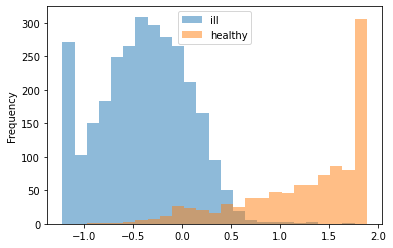

In [140]:
ill_kg = data_train[data_train['class'] == 0.0].kurtosis_glucose
healthy_kg = data_train[data_train['class'] == 1.0].kurtosis_glucose
df = pd.DataFrame({
    'ill': ill_kg,
    'healthy': healthy_kg})
ax = df.plot.hist(bins=25, alpha=0.5)

Na základe hostogamu sme si zvolili hodnotu 0.5. Tí čo budú pod touto hodnotou budú považovaný za chorých, ostatní budú považovaní za zdravých.

In [141]:
class KurtosisGlucosePredictor():
    
    def predict(self, data):
        if data <= 0.5:
            return 0.0
        else:
            return 1.0
    
    def transform(self, data):
        predicted = data['kurtosis_glucose'].apply(self.predict)
        return predicted

In [142]:
predicted_train = KurtosisGlucosePredictor().transform(data_train)

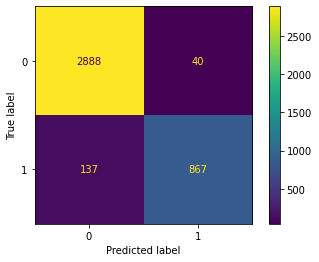

In [143]:
cm = confusion_matrix(data_train['class'], predicted_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [144]:
print(classification_report(data_train['class'], predicted_train))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2928
         1.0       0.96      0.86      0.91      1004

    accuracy                           0.95      3932
   macro avg       0.96      0.92      0.94      3932
weighted avg       0.96      0.95      0.95      3932



In [145]:
print(accuracy_score(data_train['class'], predicted_train))

0.9549847405900305


In [146]:
predicted_valid = KurtosisGlucosePredictor().transform(data_valid)

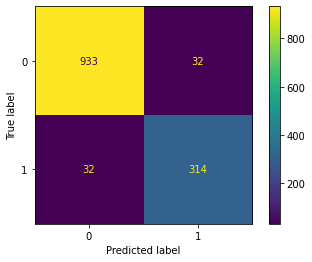

In [147]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [148]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       965
         1.0       0.91      0.91      0.91       346

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [149]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9511823035850496


### Pre tri atribúty

Zvolený atribút **kurtosis_glucose**, **mean_glucose**, **mean_oxygen**.

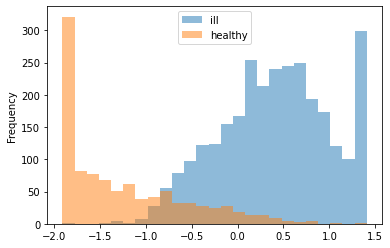

In [150]:
ill_mg = data_train[data_train['class'] == 0.0].mean_glucose
healthy_mg = data_train[data_train['class'] == 1.0].mean_glucose
df = pd.DataFrame({
    'ill': ill_mg,
    'healthy': healthy_mg})
ax = df.plot.hist(bins=25, alpha=0.5)

Vybrali sme hodnotu: -0.7

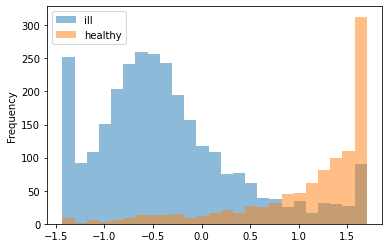

In [151]:
ill_mo = data_train[data_train['class'] == 0.0].mean_oxygen
healthy_mo = data_train[data_train['class'] == 1.0].mean_oxygen
df = pd.DataFrame({
    'ill': ill_mo,
    'healthy': healthy_mo})
ax = df.plot.hist(bins=25, alpha=0.5)

Vybrali sme hodnotu: 0.7

In [152]:
class ComplexPredictor():
    
    def predict(self, row):
        if row.kurtosis_glucose <= 0.5:
            #chorý
            if row.mean_glucose >= -0.7:
                #chorý
                if row.mean_oxygen <= 0.7:
                    return 0.0
                else:
                    return 0.0 
            else:
                if row.mean_oxygen <= 0.7:
                    return 0.0
                else:
                    return 1.0 
        else:
            #zdravý
            if row.mean_glucose >= -0.7:
                #chorý
                if row.mean_oxygen <= 0.7:
                    return 0.0
                else:
                    return 1.0 
            else:
                if row.mean_oxygen <= 0.7:
                    return 1.0
                else:
                    return 1.0 
        
    
    def transform(self, data):
        predicted = []
        for i in range(len(data)):
            predicted.append(self.predict(data.loc[i]))
            
        return pd.Series(predicted)

In [153]:
predicted_train = ComplexPredictor().transform(data_train)

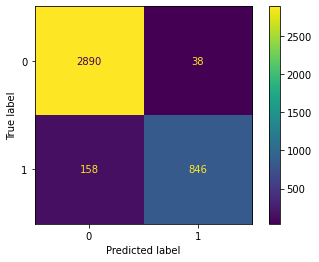

In [154]:
cm = confusion_matrix(data_train['class'], predicted_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [155]:
print(classification_report(data_train['class'], predicted_train))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2928
         1.0       0.96      0.84      0.90      1004

    accuracy                           0.95      3932
   macro avg       0.95      0.91      0.93      3932
weighted avg       0.95      0.95      0.95      3932



In [156]:
print(accuracy_score(data_train['class'], predicted_train))

0.9501525940996948


In [157]:
predicted_valid = ComplexPredictor().transform(data_valid)

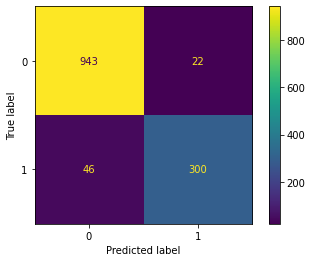

In [158]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [159]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       965
         1.0       0.93      0.87      0.90       346

    accuracy                           0.95      1311
   macro avg       0.94      0.92      0.93      1311
weighted avg       0.95      0.95      0.95      1311



In [160]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9481311975591151


class DecisionTreeClasifier:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        
    def _gini(self, n, m, num_parent):
        return 1.0 - sum((n / m) ** 2 for n in num_parent)
        
    def splitpoint(self, x, y):
        m = y.size
        if m <= 1:
            return None, None

        # Count of each class in the current node.
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        print(num_parent)

        # Gini of current node.
        best_gini = self._gini(n, m, num_parent)
        best_idx, best_thr = None, None

        # Loop through all features.
        for idx in range(self.n_features_):
            # Sort data along selected feature.
            thresholds, classes = zip(*sorted(zip(x[:, idx], y)))

            # We could actually split the node according to each feature/threshold pair
            # and count the resulting population for each class in the children, but
            # instead we compute them in an iterative fashion, making this for loop
            # linear rather than quadratic.
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):  # possible split positions
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )

                # The Gini impurity of a split is the weighted average of the Gini
                # impurity of the children.
                gini = (i * gini_left + (m - i) * gini_right) / m

                # The following condition is to make sure we don't try to split two
                # points with identical values for that feature, as it is impossible
                # (both have to end up on the same side of a split).
                if thresholds[i] == thresholds[i - 1]:
                    continue

                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2  # midpoint

        return best_idx, best_thr       

## Využitie DecisionTree z scikit-learn

[Text(163.56375, 201.90857142857143, 'X[17] <= 0.5\ngini = 0.38\nsamples = 3932\nvalue = [2928, 1004]'),
 Text(101.1375, 170.84571428571428, 'X[0] <= 78.5\ngini = 0.086\nsamples = 3026\nvalue = [2889, 137]'),
 Text(73.935, 139.78285714285715, 'X[17] <= -0.119\ngini = 0.08\nsamples = 3012\nvalue = [2886, 126]'),
 Text(36.27, 108.72, 'X[17] <= -0.449\ngini = 0.021\nsamples = 2102\nvalue = [2080, 22]'),
 Text(22.32, 77.65714285714284, 'X[18] <= -1.159\ngini = 0.006\nsamples = 1275\nvalue = [1271, 4]'),
 Text(11.16, 46.59428571428572, 'X[18] <= -1.159\ngini = 0.022\nsamples = 264\nvalue = [261, 3]'),
 Text(5.58, 15.531428571428563, 'gini = 0.015\nsamples = 263\nvalue = [261, 2]'),
 Text(16.740000000000002, 15.531428571428563, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(33.480000000000004, 46.59428571428572, 'X[14] <= 1.5\ngini = 0.002\nsamples = 1011\nvalue = [1010, 1]'),
 Text(27.9, 15.531428571428563, 'gini = 0.044\nsamples = 44\nvalue = [43, 1]'),
 Text(39.06, 15.531428571428563, 

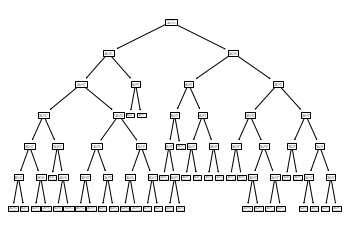

In [161]:
data_copy = data_train.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_train['class']

clf = tree.DecisionTreeClassifier(max_depth = 6)
clf = clf.fit(X, y)
predicted_train = clf.predict(X)

tree.plot_tree(clf) 

In [162]:
glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

columns = ['sex', 'race', 'marital-status', 'occupation', 'pregnant', 'education-num', 'relationship', 'capital-gain', 'fnlwgt', 'income', 'native-country', 'hours-per-week', 'capital-loss', 'workclass', 'street', 'town', 'psc'] + glucose + oxygen_age

graph = Source(export_graphviz(clf, 
                               out_file=None,
                               feature_names=columns,
                               class_names=['0.0', '1.0'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)

Format: "svg" not recognized. Use one of:


CalledProcessError: Command '['dot', '-Tsvg']' returned non-zero exit status 1. [stderr: b'Format: "svg" not recognized. Use one of:\r\n']

In [ ]:
print(classification_report(data_train['class'], predicted_train))

In [ ]:
print(accuracy_score(data_train['class'], predicted_train))

In [ ]:
cm = confusion_matrix(data_train['class'], predicted_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [ ]:
data_copy = data_valid.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_valid['class']

predicted_valid = clf.predict(X)

tree.plot_tree(clf) 

In [ ]:
print(classification_report(data_valid['class'], predicted_valid))

In [ ]:
print(accuracy_score(data_valid['class'], predicted_valid))

In [ ]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [ ]:
data_copy = data_train.drop(columns=['class', 'name', 'date_of_birth', 'education'])

In [ ]:
data_copy_v = data_valid.drop(columns=['class', 'name', 'date_of_birth', 'education'])

### Random forest

In [ ]:
forest = RandomForestClassifier(random_state=1,max_depth=3)
model = forest.fit(data_copy, data_train['class'])
y_pred_train = model.predict(data_copy)

In [ ]:
print(classification_report(data_train['class'], y_pred_train))

In [ ]:
print(accuracy_score(data_train['class'], y_pred_train))

In [ ]:
cm = confusion_matrix(data_train['class'], y_pred_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [ ]:
y_pred_valid = model.predict(data_copy_v)

In [ ]:
print(classification_report(data_valid['class'], y_pred_valid))

In [ ]:
print(accuracy_score(data_valid['class'], y_pred_valid))

In [ ]:
cm = confusion_matrix(data_valid['class'], y_pred_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

## Hyperparameter tuning

In [77]:
tcf = tree.DecisionTreeClassifier()
model = tcf.fit(data_copy, data_train['class'])
y_pred = model.predict(data_copy_v)

# print(accuracy_score(y_test, y_pred))

Popis hyperparametrov...

In [65]:
criterion = ['gini', 'entropy']
max_depth = range(1,15)
min_samples_split = range(1,15)
min_samples_leaf = range(1,10) 
max_features = range(1,10)

hyper = dict(criterion = criterion,
             max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf,
             max_features = max_features
            )
gs = GridSearchCV(tcf, param_grid=hyper, cv=10, verbose=1, n_jobs=-1)

best = gs.fit(data_copy, data_train['class'])

Fitting 10 folds for each of 31752 candidates, totalling 317520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 5904 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 9504 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 13904 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 19104 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 25104 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 31904 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 39504 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 47904 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 57104 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 67104 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 77904 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 89504 

In [66]:
gs.best_estimator_

DecisionTreeClassifier(max_depth=6, max_features=8, min_samples_leaf=6,
                       min_samples_split=12)

[Text(190.4529661016949, 201.90857142857143, 'X[18] <= 0.914\ngini = 0.38\nsamples = 3932\nvalue = [2928, 1004]'),
 Text(109.94491525423729, 170.84571428571428, 'X[19] <= 0.895\ngini = 0.145\nsamples = 3148\nvalue = [2901, 247]'),
 Text(45.396610169491524, 139.78285714285715, 'X[18] <= 0.022\ngini = 0.088\nsamples = 2802\nvalue = [2672, 130]'),
 Text(22.698305084745762, 108.72, 'X[0] <= 77.5\ngini = 0.044\nsamples = 2024\nvalue = [1978, 46]'),
 Text(17.023728813559323, 77.65714285714284, 'X[20] <= 0.981\ngini = 0.04\nsamples = 2015\nvalue = [1974, 41]'),
 Text(11.349152542372881, 46.59428571428572, 'X[20] <= -0.122\ngini = 0.037\nsamples = 2007\nvalue = [1969, 38]'),
 Text(5.6745762711864405, 15.531428571428563, 'gini = 0.02\nsamples = 1414\nvalue = [1400, 14]'),
 Text(17.023728813559323, 15.531428571428563, 'gini = 0.078\nsamples = 593\nvalue = [569, 24]'),
 Text(22.698305084745762, 46.59428571428572, 'gini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(28.3728813559322, 77.65714285714

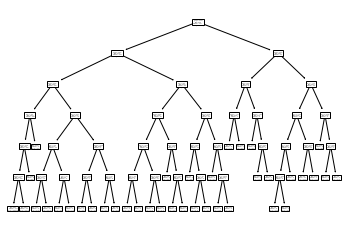

In [78]:
clf = tree.DecisionTreeClassifier(max_depth=6, max_features=8, min_samples_leaf=6, min_samples_split=12)
clf = clf.fit(data_copy, data_train['class'])
predicted_train = clf.predict(data_copy)

tree.plot_tree(clf) 

In [79]:
print(classification_report(data_train['class'], predicted_train))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98      2928
         1.0       0.97      0.89      0.93      1004

    accuracy                           0.96      3932
   macro avg       0.97      0.94      0.95      3932
weighted avg       0.96      0.96      0.96      3932



In [80]:
print(accuracy_score(data_train['class'], predicted_train))

0.9643947100712106


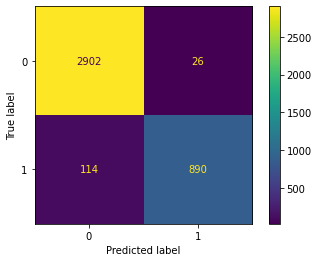

In [81]:
cm = confusion_matrix(data_train['class'], predicted_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

[Text(190.4529661016949, 201.90857142857143, 'X[18] <= 0.914\ngini = 0.38\nsamples = 3932\nvalue = [2928, 1004]'),
 Text(109.94491525423729, 170.84571428571428, 'X[19] <= 0.895\ngini = 0.145\nsamples = 3148\nvalue = [2901, 247]'),
 Text(45.396610169491524, 139.78285714285715, 'X[18] <= 0.022\ngini = 0.088\nsamples = 2802\nvalue = [2672, 130]'),
 Text(22.698305084745762, 108.72, 'X[0] <= 77.5\ngini = 0.044\nsamples = 2024\nvalue = [1978, 46]'),
 Text(17.023728813559323, 77.65714285714284, 'X[20] <= 0.981\ngini = 0.04\nsamples = 2015\nvalue = [1974, 41]'),
 Text(11.349152542372881, 46.59428571428572, 'X[20] <= -0.122\ngini = 0.037\nsamples = 2007\nvalue = [1969, 38]'),
 Text(5.6745762711864405, 15.531428571428563, 'gini = 0.02\nsamples = 1414\nvalue = [1400, 14]'),
 Text(17.023728813559323, 15.531428571428563, 'gini = 0.078\nsamples = 593\nvalue = [569, 24]'),
 Text(22.698305084745762, 46.59428571428572, 'gini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(28.3728813559322, 77.65714285714

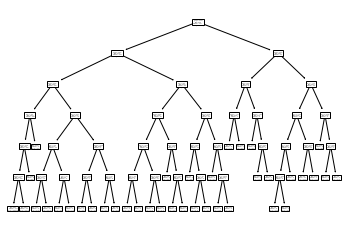

In [82]:
# clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
# clf = clf.fit(X, y)
predicted_valid = clf.predict(data_copy_v)

tree.plot_tree(clf) 

In [83]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       965
         1.0       0.93      0.89      0.91       346

    accuracy                           0.95      1311
   macro avg       0.95      0.93      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [84]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.954233409610984


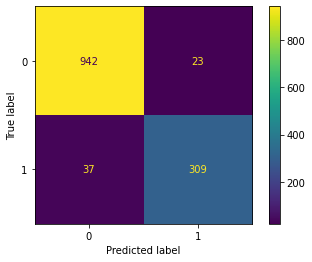

In [85]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

## Vyhodnotenie vplyvu zvolenej stratégie nahrádzania chýbajúcich hodnôt na správnosť klasifikácie

Všetky číselné atribúty sme nahradili priemerom.

In [86]:
personal_train = pd.read_csv('personal_train.csv', index_col='Unnamed: 0')

In [87]:
other_train = pd.read_csv('other_train.csv', index_col='Unnamed: 0')

In [88]:
personal_valid = pd.read_csv('personal_valid.csv', index_col='Unnamed: 0')

In [89]:
other_valid = pd.read_csv('other_valid.csv', index_col='Unnamed: 0')

In [90]:
merge = Pipeline([('merge', MergeTransformer(personal_train, other_train, ['name', 'address']))])

data_train = pd.DataFrame()
data_train = merge.transform(data_train)

In [91]:
most_frequent_missing = ['education-num','race', 'marital-status', 'occupation', 'relationship', 'native-country', 'workclass', 'capital-gain', 'capital-loss']

glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

encode = ['sex', 'race', 'marital-status', 'occupation', 'relationship', 'income', 'native-country', 'workclass', 'town', 'psc', 'street']

outliers = ['fnlwgt', 'mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']

pip = Pipeline([('split_medical', SplittingMedicalTransformer()),
               ('deduplication', DeduplicationTransformer(['name','address'])),
               ('strip', StripTransformer(['sex', 'race', 'marital-status', 'occupation', 'relationship', 'education', 'income', 'native-country', 'workclass'])),
               ('nan_unification', UnificationToNanTransformer()),
               ('date_unification', DateUnificationTransformer()),
               ('address_unification', AddressUnificationTransformer()),
               ('age_unification', AgeUnificationTransformer()),
               ('pregnant_unification', PregnantUnificationTransformer()),
               ('workclass_unification', WorkclassUnificationTransformer()),
               ('relationship_unification', RelationshipUnificationTransformer()),
               ('age_to_nan', AgeToNanTransformer()),
               ('most_frequent_missing', MostFrequentTransformer(most_frequent_missing)),
               ('class_remove', ClassRemovalTransformer()),
               ('hours-per-week', MeanTransformer(['hours-per-week'])),
               ('glucose', MeanTransformer(glucose)),
               ('oxygen_age', MeanTransformer(oxygen_age)),
               ('power_transform',PowerTransformTransformer(outliers)),
               ('outliers', OutliersTransformer(outliers)),
               ('encode', LabelEncoderTransformer(encode))])

pip.fit(data_train)
data_train = pip.transform(data_train)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 22


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 3


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 17


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 18


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  ske

In [92]:
merge = Pipeline([('merge', MergeTransformer(personal_valid, other_valid, ['name', 'address']))])

data_valid = pd.DataFrame()
data_valid = merge.transform(data_valid)

In [93]:
data_valid = pip.transform(data_valid)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 2


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 0


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  skewne

### Testovanie DecisionTree

[Text(165.59612068965515, 201.90857142857143, 'X[17] <= 0.5\ngini = 0.38\nsamples = 3932\nvalue = [2928, 1004]'),
 Text(104.625, 170.84571428571428, 'X[0] <= 78.5\ngini = 0.086\nsamples = 3026\nvalue = [2889, 137]'),
 Text(76.48448275862069, 139.78285714285715, 'X[17] <= -0.119\ngini = 0.08\nsamples = 3012\nvalue = [2886, 126]'),
 Text(37.52068965517241, 108.72, 'X[17] <= -0.449\ngini = 0.021\nsamples = 2102\nvalue = [2080, 22]'),
 Text(23.089655172413792, 77.65714285714284, 'X[18] <= -1.159\ngini = 0.006\nsamples = 1275\nvalue = [1271, 4]'),
 Text(11.544827586206896, 46.59428571428572, 'X[18] <= -1.159\ngini = 0.022\nsamples = 264\nvalue = [261, 3]'),
 Text(5.772413793103448, 15.531428571428563, 'gini = 0.015\nsamples = 263\nvalue = [261, 2]'),
 Text(17.317241379310346, 15.531428571428563, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(34.63448275862069, 46.59428571428572, 'X[14] <= 1.5\ngini = 0.002\nsamples = 1011\nvalue = [1010, 1]'),
 Text(28.86206896551724, 15.531428571428563,

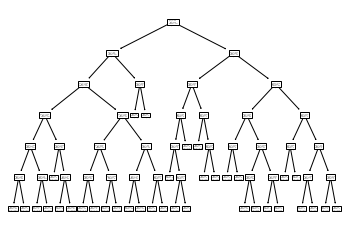

In [94]:
data_copy = data_train.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_train['class']

clf = tree.DecisionTreeClassifier(max_depth = 6)
clf = clf.fit(X, y)
predicted_train = clf.predict(X)

tree.plot_tree(clf) 

In [95]:
print(classification_report(data_train['class'], predicted_train))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2928
         1.0       0.98      0.91      0.94      1004

    accuracy                           0.97      3932
   macro avg       0.98      0.95      0.96      3932
weighted avg       0.97      0.97      0.97      3932



In [96]:
print(accuracy_score(data_train['class'], predicted_train))

0.9725330620549338


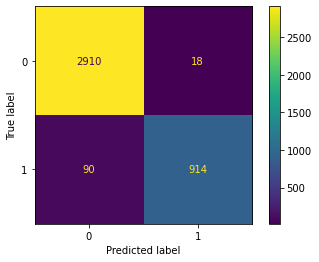

In [97]:
cm = confusion_matrix(data_train['class'], predicted_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

[Text(165.59612068965515, 201.90857142857143, 'X[17] <= 0.5\ngini = 0.38\nsamples = 3932\nvalue = [2928, 1004]'),
 Text(104.625, 170.84571428571428, 'X[0] <= 78.5\ngini = 0.086\nsamples = 3026\nvalue = [2889, 137]'),
 Text(76.48448275862069, 139.78285714285715, 'X[17] <= -0.119\ngini = 0.08\nsamples = 3012\nvalue = [2886, 126]'),
 Text(37.52068965517241, 108.72, 'X[17] <= -0.449\ngini = 0.021\nsamples = 2102\nvalue = [2080, 22]'),
 Text(23.089655172413792, 77.65714285714284, 'X[18] <= -1.159\ngini = 0.006\nsamples = 1275\nvalue = [1271, 4]'),
 Text(11.544827586206896, 46.59428571428572, 'X[18] <= -1.159\ngini = 0.022\nsamples = 264\nvalue = [261, 3]'),
 Text(5.772413793103448, 15.531428571428563, 'gini = 0.015\nsamples = 263\nvalue = [261, 2]'),
 Text(17.317241379310346, 15.531428571428563, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(34.63448275862069, 46.59428571428572, 'X[14] <= 1.5\ngini = 0.002\nsamples = 1011\nvalue = [1010, 1]'),
 Text(28.86206896551724, 15.531428571428563,

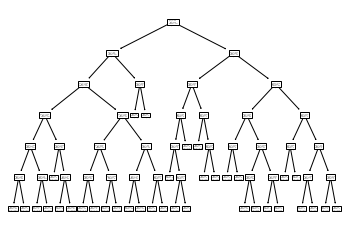

In [98]:
data_copy = data_valid.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_valid['class']

predicted_valid = clf.predict(X)

tree.plot_tree(clf) 

In [99]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       965
         1.0       0.87      0.93      0.90       346

    accuracy                           0.95      1311
   macro avg       0.92      0.94      0.93      1311
weighted avg       0.95      0.95      0.95      1311



In [100]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9450800915331807


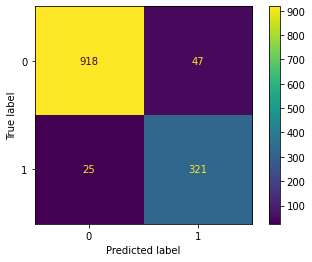

In [101]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

### cez K najbližších

In [102]:
merge = Pipeline([('merge', MergeTransformer(personal_train, other_train, ['name', 'address']))])

data_train = pd.DataFrame()
data_train = merge.transform(data_train)

In [103]:
most_frequent_missing = ['education-num','race', 'marital-status', 'occupation', 'relationship', 'native-country', 'workclass', 'capital-gain', 'capital-loss']

glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

encode = ['sex', 'race', 'marital-status', 'occupation', 'relationship', 'income', 'native-country', 'workclass', 'town', 'psc', 'street']

outliers = ['fnlwgt', 'mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']

pip = Pipeline([('split_medical', SplittingMedicalTransformer()),
               ('deduplication', DeduplicationTransformer(['name','address'])),
               ('strip', StripTransformer(['sex', 'race', 'marital-status', 'occupation', 'relationship', 'education', 'income', 'native-country', 'workclass'])),
               ('nan_unification', UnificationToNanTransformer()),
               ('date_unification', DateUnificationTransformer()),
               ('address_unification', AddressUnificationTransformer()),
               ('age_unification', AgeUnificationTransformer()),
               ('pregnant_unification', PregnantUnificationTransformer()),
               ('workclass_unification', WorkclassUnificationTransformer()),
               ('relationship_unification', RelationshipUnificationTransformer()),
               ('age_to_nan', AgeToNanTransformer()),
               ('most_frequent_missing', MostFrequentTransformer(most_frequent_missing)),
               ('class_remove', ClassRemovalTransformer()),
               ('hours-per-week', KNNTransformer(['hours-per-week'])),
               ('glucose', KNNTransformer(glucose)),
               ('oxygen_age', KNNTransformer(oxygen_age)),
               ('power_transform',PowerTransformTransformer(outliers)),
               ('outliers', OutliersTransformer(outliers)),
               ('encode', LabelEncoderTransformer(encode))])

pip.fit(data_train)
data_train = pip.transform(data_train)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 22


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 3


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 17


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 18


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  ske

In [104]:
merge = Pipeline([('merge', MergeTransformer(personal_valid, other_valid, ['name', 'address']))])

data_valid = pd.DataFrame()
data_valid = merge.transform(data_valid)

In [105]:
data_valid = pip.transform(data_valid)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 2


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 0


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  skewne

[Text(165.59612068965515, 201.90857142857143, 'X[17] <= 0.5\ngini = 0.38\nsamples = 3932\nvalue = [2928, 1004]'),
 Text(104.625, 170.84571428571428, 'X[0] <= 78.5\ngini = 0.086\nsamples = 3026\nvalue = [2889, 137]'),
 Text(76.48448275862069, 139.78285714285715, 'X[17] <= -0.119\ngini = 0.08\nsamples = 3012\nvalue = [2886, 126]'),
 Text(37.52068965517241, 108.72, 'X[17] <= -0.449\ngini = 0.021\nsamples = 2102\nvalue = [2080, 22]'),
 Text(23.089655172413792, 77.65714285714284, 'X[18] <= -1.159\ngini = 0.006\nsamples = 1275\nvalue = [1271, 4]'),
 Text(11.544827586206896, 46.59428571428572, 'X[18] <= -1.159\ngini = 0.022\nsamples = 264\nvalue = [261, 3]'),
 Text(5.772413793103448, 15.531428571428563, 'gini = 0.015\nsamples = 263\nvalue = [261, 2]'),
 Text(17.317241379310346, 15.531428571428563, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(34.63448275862069, 46.59428571428572, 'X[14] <= 1.5\ngini = 0.002\nsamples = 1011\nvalue = [1010, 1]'),
 Text(28.86206896551724, 15.531428571428563,

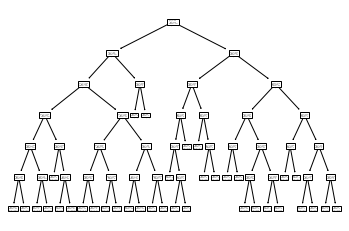

In [106]:
data_copy = data_train.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_train['class']

clf = tree.DecisionTreeClassifier(max_depth = 6)
clf = clf.fit(X, y)
predicted_train = clf.predict(X)

tree.plot_tree(clf) 

In [107]:
print(classification_report(data_train['class'], predicted_train))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2928
         1.0       0.98      0.91      0.94      1004

    accuracy                           0.97      3932
   macro avg       0.98      0.95      0.96      3932
weighted avg       0.97      0.97      0.97      3932



In [108]:
print(accuracy_score(data_train['class'], predicted_train))

0.9725330620549338


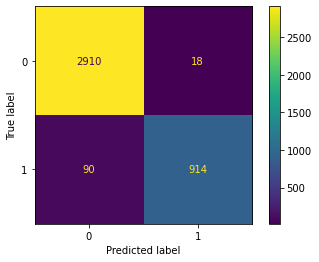

In [109]:
cm = confusion_matrix(data_train['class'], predicted_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

[Text(165.59612068965515, 201.90857142857143, 'X[17] <= 0.5\ngini = 0.38\nsamples = 3932\nvalue = [2928, 1004]'),
 Text(104.625, 170.84571428571428, 'X[0] <= 78.5\ngini = 0.086\nsamples = 3026\nvalue = [2889, 137]'),
 Text(76.48448275862069, 139.78285714285715, 'X[17] <= -0.119\ngini = 0.08\nsamples = 3012\nvalue = [2886, 126]'),
 Text(37.52068965517241, 108.72, 'X[17] <= -0.449\ngini = 0.021\nsamples = 2102\nvalue = [2080, 22]'),
 Text(23.089655172413792, 77.65714285714284, 'X[18] <= -1.159\ngini = 0.006\nsamples = 1275\nvalue = [1271, 4]'),
 Text(11.544827586206896, 46.59428571428572, 'X[18] <= -1.159\ngini = 0.022\nsamples = 264\nvalue = [261, 3]'),
 Text(5.772413793103448, 15.531428571428563, 'gini = 0.015\nsamples = 263\nvalue = [261, 2]'),
 Text(17.317241379310346, 15.531428571428563, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(34.63448275862069, 46.59428571428572, 'X[14] <= 1.5\ngini = 0.002\nsamples = 1011\nvalue = [1010, 1]'),
 Text(28.86206896551724, 15.531428571428563,

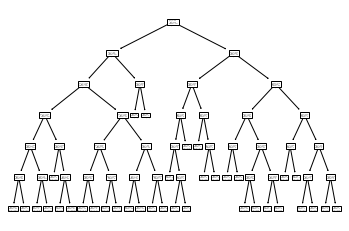

In [110]:
data_copy = data_valid.drop(columns=['class', 'name', 'date_of_birth', 'education'])
X = data_copy
y = data_valid['class']

predicted_valid = clf.predict(X)

tree.plot_tree(clf) 

In [111]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       965
         1.0       0.87      0.94      0.90       346

    accuracy                           0.95      1311
   macro avg       0.92      0.95      0.93      1311
weighted avg       0.95      0.95      0.95      1311



In [112]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9466056445461479


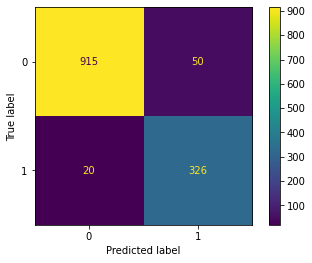

In [113]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

Minimálny vplyv, ....  Z tých 3 čo sme otestovali tá z priemerom do všetkých...